In [80]:
from kan import KAN
import torch
import copy
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 26

model = KAN(width=[6,4,1], grid=3, k=3, seed=seed, device=device)

# create dataset


def create_dataset(train_num=500, test_num=500):

    def generate_contrastive(x):
        # positive samples
        batch = x.shape[0]
        x[:,2] = torch.exp(torch.sin(torch.pi*x[:,0])+x[:,1]**2)
        x[:,3] = x[:,4]**3

        # negative samples
        def corrupt(tensor):
            y = copy.deepcopy(tensor)
            for i in range(y.shape[1]):
                y[:,i] = y[:,i][torch.randperm(y.shape[0])]
            return y

        x_cor = corrupt(x)
        x = torch.cat([x, x_cor], dim=0)
        y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
        return x, y

    x = torch.rand(train_num, 6) * 2 - 1
    x_train, y_train = generate_contrastive(x)

    x = torch.rand(test_num, 6) * 2 - 1
    x_test, y_test = generate_contrastive(x)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

dataset = create_dataset()

cpu
checkpoint directory created: ./model
saving model version 0.0


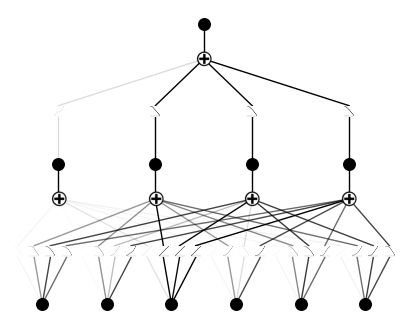

In [81]:
model(dataset['train_input'])
model.plot(beta=10)

In [82]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

saving model version 0.1


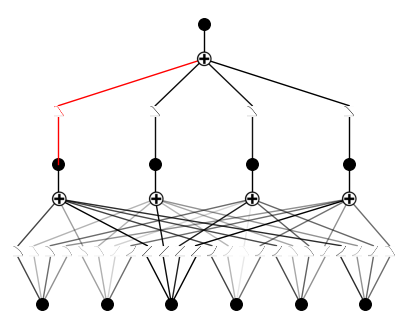

In [83]:
model(dataset['train_input'])
model.plot(beta=10)

In [84]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=10.0, lamb_coef=1.0);

| train_loss: 2.55e-01 | test_loss: 2.61e-01 | reg: 1.32e+01 | : 100%|█| 50/50 [00:34<00:00,  1.44it

saving model version 0.2


In [85]:
model = model.prune()

saving model version 0.3


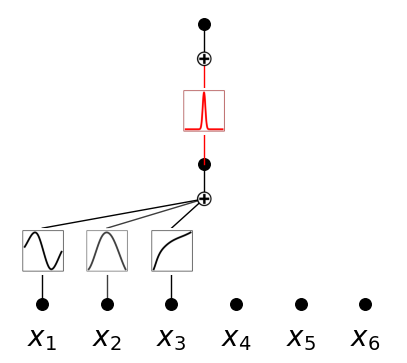

In [88]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

In [101]:
#evaluate the above model
model.eval()

y_pred = model(dataset['test_input'])
y_pred = (y_pred > 0.5).float()
accuracy_score(dataset['test_label'].cpu().detach().numpy(), y_pred.cpu().detach().numpy())

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [95]:
dataset['train_input'][1]

tensor([ 0.8629, -0.1190,  1.5398, -0.4035, -0.7390, -0.1002])

In [93]:
#transform the dataset['train_input'] to dataframe
import pandas as pd
import numpy as np
df = pd.DataFrame(dataset['train_input'].cpu().detach().numpy())
df['label'] = dataset['train_label'].cpu().detach().numpy()
df.head()

,0,1,2,3,4,5,label
0,-0.263541,0.570015,0.662575,-0.057066,-0.384999,-0.121455,1.0
1,0.862920,-0.118994,1.539751,-0.403549,-0.738979,-0.100160,1.0
2,-0.739637,-0.012581,0.482106,0.454678,0.768956,0.481454,1.0
3,0.291674,-0.646327,3.357195,-0.334387,-0.694091,-0.458365,1.0
4,0.808057,-0.433384,2.127489,-0.893256,-0.963072,-0.489371,1.0


In [97]:
#transform the dataset['test_input'] to dataframe
df_test = pd.DataFrame(dataset['test_input'].cpu().detach().numpy())
df_test['label'] = dataset['test_label'].cpu().detach().numpy()
df_test.head()

,0,1,2,3,4,5,label
0,0.168655,-0.856553,3.452446,0.155153,0.537346,0.751107,1.0
1,-0.048928,0.140509,0.875145,-0.319458,-0.683604,0.444233,1.0
2,-0.278084,0.085117,0.467939,0.616226,0.850968,0.720365,1.0
3,0.456587,-0.809181,5.183535,-0.060460,-0.392485,0.618410,1.0
4,-0.805894,0.632067,0.840972,-0.660425,-0.870846,0.108477,1.0


In [124]:
#create a simple mlp model to compare the performance

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)
    
mlp = MLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

In [125]:
#train the mlp model
epochs = 100
batch_size = 32
train_dataset = TensorDataset(dataset['train_input'], dataset['train_label'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = mlp(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.785248875617981
Epoch 10, Loss: 0.4439186155796051
Epoch 20, Loss: 0.3550851047039032
Epoch 30, Loss: 0.1234915554523468
Epoch 40, Loss: 0.025139588862657547
Epoch 50, Loss: 0.04824863001704216
Epoch 60, Loss: 0.03809578716754913
Epoch 70, Loss: 0.1374446600675583
Epoch 80, Loss: 0.01662135124206543
Epoch 90, Loss: 0.36322125792503357


In [126]:
#create an early stopper for the mlp and apply it on the training
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
class EarlyStopping(BaseEstimator):
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    def fit(self, model, x, y):
        self.best_score = np.inf
        for epoch in range(100):
            for i, (x, y) in enumerate(train_loader):
                optimizer.zero_grad()
                y_pred = mlp(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
            y_pred = mlp(dataset['test_input'])
            y_pred = (y_pred > 0.5).float()
            score = accuracy_score(dataset['test_label'].cpu().detach().numpy(), y_pred.cpu().detach().numpy())
            if score < self.best_score:
                self.best_score = score
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    break
        return self
    
early_stopper = EarlyStopping(patience=5)
early_stopper.fit(mlp, dataset['train_input'], dataset['train_label'])


Epoch 0, Loss: 0.05263559892773628


EarlyStopping()

In [127]:
#evaluate the mlp model
mlp.eval()
y_pred = mlp(dataset['test_input'])
y_pred = (y_pred > 0.5).float()
accuracy_score(dataset['test_label'].cpu().detach().numpy(), y_pred.cpu().detach().numpy())

0.921

In [128]:
#evaluate the above model
model.eval()

y_pred = model(dataset['test_input'])
y_pred = (y_pred > 0.5).float()
accuracy_score(dataset['test_label'].cpu().detach().numpy(), y_pred.cpu().detach().numpy())

0.903

In [131]:
#show the number of parameters on mlp

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

84

In [132]:
count_parameters(mlp)

1313